In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [ ]:
!pip install klib

In [ ]:
from sklearn.preprocessing import MinMaxScaler
#from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
#from tensorflow import set_random_seed
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
import tensorflow as tf
tf.random.set_seed(0)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
import klib

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

*num_passengers = number of passengers travelling

sales_channel = sales channel booking was made on

trip_type = trip Type (Round Trip, One Way, Circle Trip)

purchase_lead = number of days between travel date and booking date

length_of_stay = number of days spent at destination

flight_hour = hour of flight departure

flight_day = day of week of flight departure

route = origin -> destination flight route

booking_origin = country from where booking was made

wants_extra_baggage = if the customer wanted extra baggage in the booking

wants_preferred_seat = if the customer wanted a preferred seat in the booking

wants_in_flight_meals = if the customer wanted in-flight meals in the booking

flight_duration = total duration of flight (in hours)

booking_complete = flag indicating if the customer completed the booking
*




In [ ]:
def read_file_safely(file_path):
    """
    Attempts to read a file using multiple encoding strategies.
    Returns the file content and the successful encoding used.

    Args:
        file_path (str): Path to the file to read

    Returns:
        tuple: (file_content, encoding_used)

    Raises:
        ValueError: If no encoding strategy works
    """
    # List of encodings to try
    encodings = [
        'utf-8',
        'utf-8-sig',  # UTF-8 with BOM
        'latin-1',    # Also known as ISO-8859-1
        'cp1252',     # Windows-1252
        'ascii',
        'utf-16'
    ]

    # Try each encoding
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as file:
                content = file.read()
                return content, encoding
        except UnicodeDecodeError:
            continue

    # If no encoding worked, try reading in binary mode and handle errors
    try:
        with open(file_path, 'r', encoding='utf-8', errors='replace') as file:
            content = file.read()
            return content, 'utf-8 with replacement'
    except Exception as e:
        raise ValueError(f"Could not decode file with any encoding: {str(e)}")

# Example usage:
try:
    content, encoding = read_file_safely('your_file.txt')
    print(f"Successfully read file using {encoding} encoding")
    print("Content:", content[:100])  # Print first 100 chars
except ValueError as e:
    print(f"Error reading file: {e}")

Successfully loaded CSV using latin-1 encoding

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int

In [ ]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [ ]:
df.shape

(50000, 14)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pickle
def fit_label_encoders(df: pd.DataFrame, save_path: str) -> (pd.DataFrame, dict):
    label_encoders = {}
    for col in df.columns:
        if df[col].dtype == 'object' :
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
    # Save label_encoders to disk
    with open(save_path, 'wb') as f:
        pickle.dump(label_encoders, f)

    return df, label_encoders

In [ ]:
fit_label_encoders(df, 'label_encoders.pkl')

(       num_passengers  sales_channel  trip_type  purchase_lead  \
 0                   2              0          2            262   
 1                   1              0          2            112   
 2                   2              0          2            243   
 3                   1              0          2             96   
 4                   2              0          2             68   
 ...               ...            ...        ...            ...   
 49995               2              0          2             27   
 49996               1              0          2            111   
 49997               1              0          2             24   
 49998               1              0          2             15   
 49999               1              0          2             19   
 
        length_of_stay  flight_hour  flight_day  route  booking_origin  \
 0                  19            7           2      0              61   
 1                  20            3           

In [ ]:
df["wants_extra_baggage"].value_counts()

,count
wants_extra_baggage,
1,33439
0,16561


In [ ]:
col1=df.columns
for i in col1:
    print(i)
    value_count(df, i)

num_passengers
num_passengers
1    31352
2    12804
3     2941
4     1784
5      561
6      289
7      114
8       89
9       66
Name: count, dtype: int64
sales_channel
sales_channel
0    44382
1     5618
Name: count, dtype: int64
trip_type
trip_type
2    49497
1      387
0      116
Name: count, dtype: int64
purchase_lead
purchase_lead
1      685
2      670
6      653
7      638
5      615
      ... 
641      1
471      1
614      1
463      1
867      1
Name: count, Length: 470, dtype: int64
length_of_stay
length_of_stay
6      7757
5      7286
4      5655
3      2839
17     1849
       ... 
226       1
778       1
610       1
308       1
356       1
Name: count, Length: 335, dtype: int64
flight_hour
flight_hour
8     3165
12    3163
9     3132
7     3126
11    3110
13    3101
10    3085
6     3050
5     2851
4     2843
14    2833
3     2655
2     2642
15    2234
1     2089
16    1557
0     1539
23     986
17     861
22     579
18     439
21     389
19     295
20     276
Name: count, 

In [ ]:
df["wants_in_flight_meals"].value_counts()

,count
wants_in_flight_meals,
0,28643
1,21357


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  int64  
 2   trip_type              50000 non-null  int64  
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  int64  
 8   booking_origin         50000 non-null  int64  
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 5.3 MB


In [ ]:
df.corr(numeric_only=True)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
num_passengers,1.000000,-0.002457,0.002261,0.212606,-0.115850,0.015607,-0.002243,-0.048508,0.052341,0.120404,0.028544,0.022943,-0.063169,0.024116
sales_channel,-0.002457,1.000000,0.021237,-0.013399,-0.060352,0.022375,-0.022759,-0.020717,0.026449,-0.054254,0.032943,-0.022235,-0.038629,-0.041060
trip_type,0.002261,0.021237,1.000000,-0.008443,0.006510,-0.002758,-0.000892,-0.008754,0.002355,-0.014078,0.005668,0.011955,-0.039071,0.027021
purchase_lead,0.212606,-0.013399,-0.008443,1.000000,-0.076560,0.035973,-0.031403,-0.107435,0.048180,-0.022207,-0.004499,-0.022653,0.067866,-0.022131
length_of_stay,-0.115850,-0.060352,0.006510,-0.076560,1.000000,-0.024872,0.002472,0.003427,-0.110355,0.176757,0.032264,0.098828,0.141181,-0.042408
flight_hour,0.015607,0.022375,-0.002758,0.035973,-0.024872,1.000000,0.009192,-0.016735,0.042426,-0.011434,0.012171,0.013014,-0.002101,0.007127
flight_day,-0.002243,-0.022759,-0.000892,-0.031403,0.002472,0.009192,1.000000,0.003176,0.000476,0.005714,-0.005376,-0.005199,-0.001757,0.010929
route,-0.048508,-0.020717,-0.008754,-0.107435,0.003427,-0.016735,0.003176,1.000000,-0.067710,0.026334,0.016270,-0.011232,-0.137320,-0.008488
booking_origin,0.052341,0.026449,0.002355,0.048180,-0.110355,0.042426,0.000476,-0.067710,1.000000,-0.028995,-0.050763,-0.084314,-0.230364,0.130804
wants_extra_baggage,0.120404,-0.054254,-0.014078,-0.022207,0.176757,-0.011434,0.005714,0.026334,-0.028995,1.000000,0.207669,0.216470,0.057054,0.068139


In [ ]:
df.corr(numeric_only=True).style.background_gradient(cmap='coolwarm')

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
num_passengers,1.000000,-0.002457,0.002261,0.212606,-0.115850,0.015607,-0.002243,-0.048508,0.052341,0.120404,0.028544,0.022943,-0.063169,0.024116
sales_channel,-0.002457,1.000000,0.021237,-0.013399,-0.060352,0.022375,-0.022759,-0.020717,0.026449,-0.054254,0.032943,-0.022235,-0.038629,-0.041060
trip_type,0.002261,0.021237,1.000000,-0.008443,0.006510,-0.002758,-0.000892,-0.008754,0.002355,-0.014078,0.005668,0.011955,-0.039071,0.027021
purchase_lead,0.212606,-0.013399,-0.008443,1.000000,-0.076560,0.035973,-0.031403,-0.107435,0.048180,-0.022207,-0.004499,-0.022653,0.067866,-0.022131
length_of_stay,-0.115850,-0.060352,0.006510,-0.076560,1.000000,-0.024872,0.002472,0.003427,-0.110355,0.176757,0.032264,0.098828,0.141181,-0.042408
flight_hour,0.015607,0.022375,-0.002758,0.035973,-0.024872,1.000000,0.009192,-0.016735,0.042426,-0.011434,0.012171,0.013014,-0.002101,0.007127
flight_day,-0.002243,-0.022759,-0.000892,-0.031403,0.002472,0.009192,1.000000,0.003176,0.000476,0.005714,-0.005376,-0.005199,-0.001757,0.010929
route,-0.048508,-0.020717,-0.008754,-0.107435,0.003427,-0.016735,0.003176,1.000000,-0.067710,0.026334,0.016270,-0.011232,-0.137320,-0.008488
booking_origin,0.052341,0.026449,0.002355,0.048180,-0.110355,0.042426,0.000476,-0.067710,1.000000,-0.028995,-0.050763,-0.084314,-0.230364,0.130804
wants_extra_baggage,0.120404,-0.054254,-0.014078,-0.022207,0.176757,-0.011434,0.005714,0.026334,-0.028995,1.000000,0.207669,0.216470,0.057054,0.068139


<Axes: title={'center': 'Feature-correlation (pearson)'}>

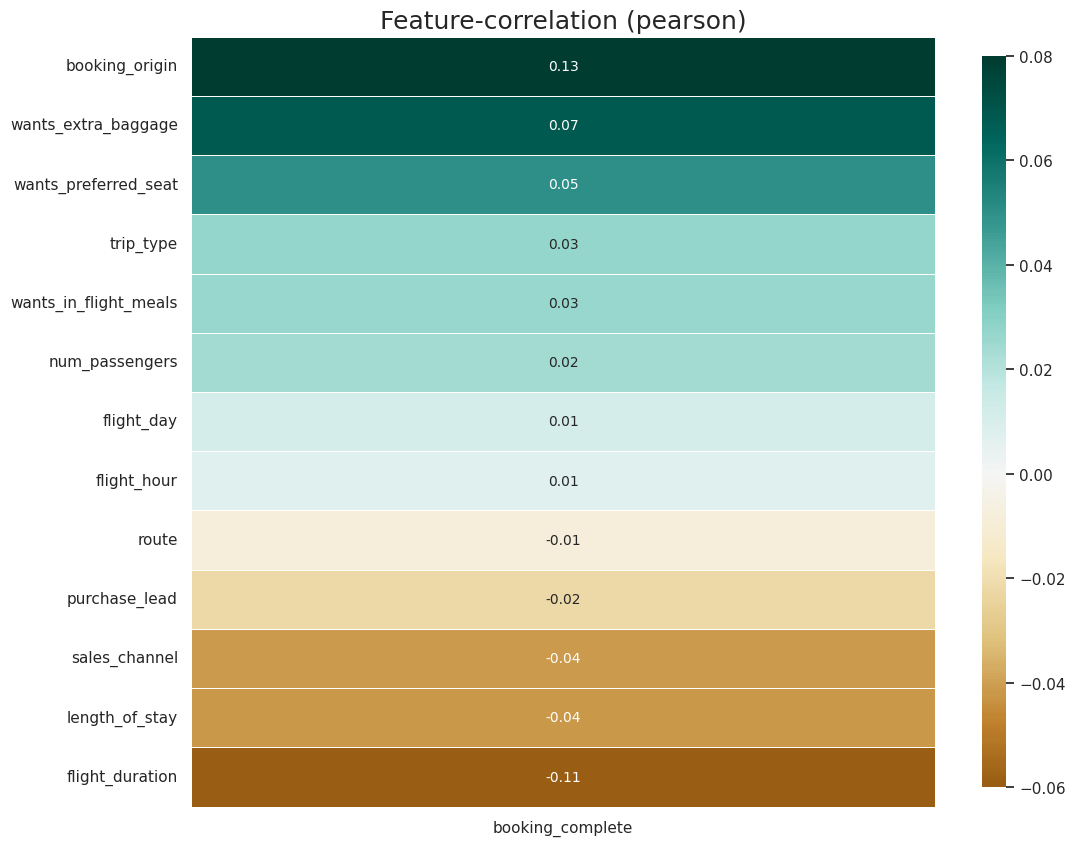

In [ ]:
klib.corr_plot(df, target='booking_complete')

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

def value_count_bargraph(df):
    """
    Creates a bar graph to show the value counts for each column in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame
    """
    fig, axes = plt.subplots(len(df.columns), 1, figsize=(12, 3*len(df.columns)), squeeze=False)

    for i, col in enumerate(df.columns):
        df[col].value_counts().plot(kind='bar', ax=axes[i,0], title=col)
        axes[i,0].set_xlabel('')

    plt.tight_layout()
    plt.show()

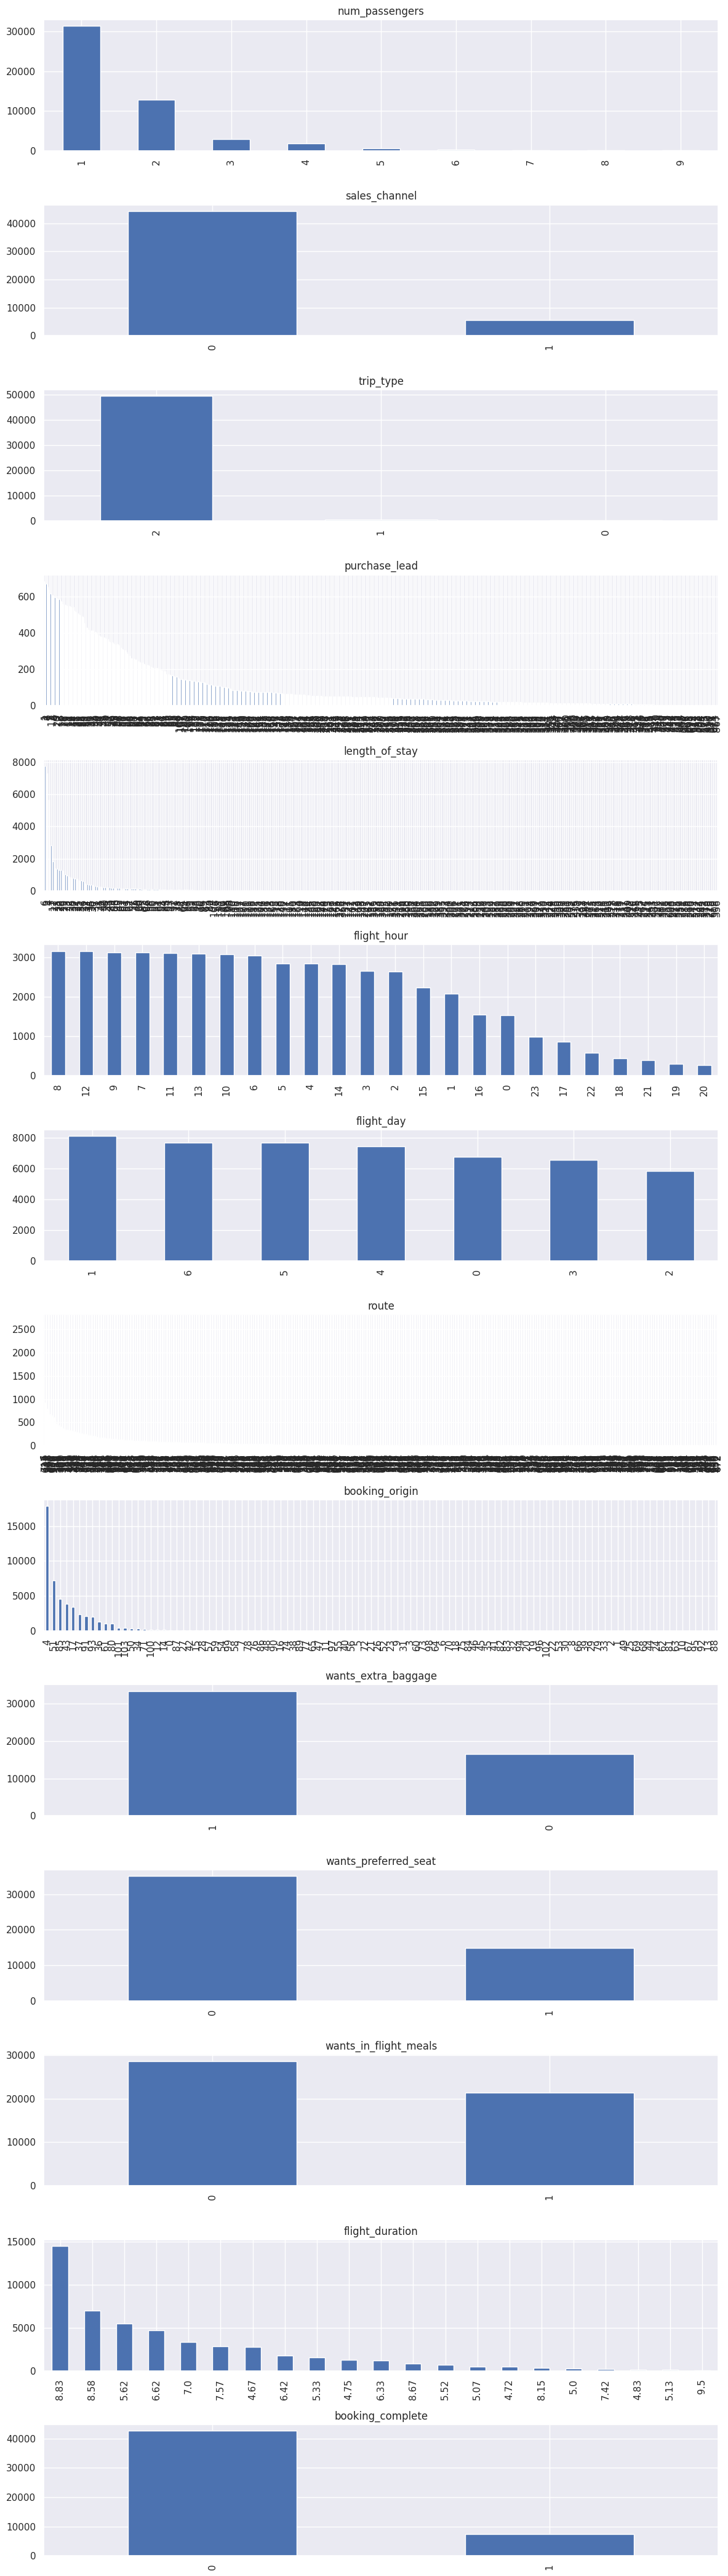

In [40]:
value_count_bargraph(df)

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

def value_count_seaborn(df):
    """
    Creates a bar plot using Seaborn to show the value counts for each column in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame
    """
    fig, axes = plt.subplots(len(df.columns), 1, figsize=(12, 3*len(df.columns)), squeeze=False)

    for i, col in enumerate(df.columns):
        sns.countplot(x=df[col], ax=axes[i,0])
        axes[i,0].set_title(col)
        axes[i,0].set_xlabel('')

    plt.tight_layout()
    plt.show()

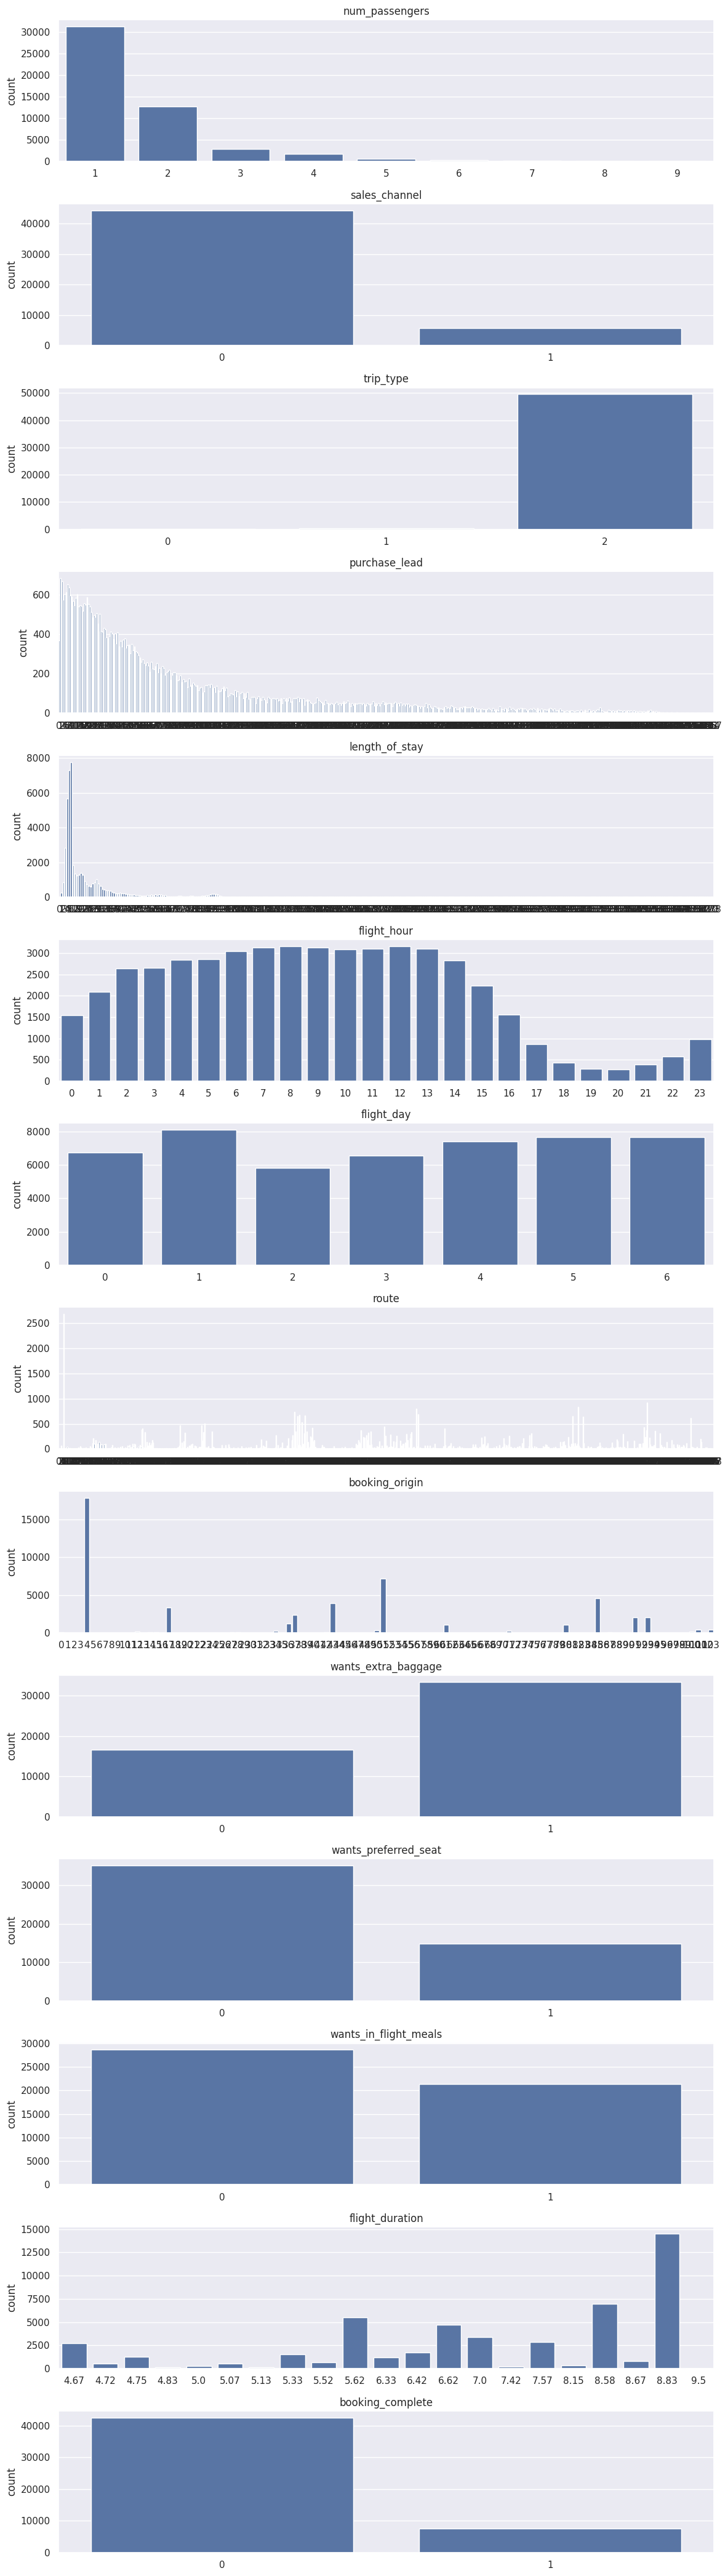

In [42]:
value_count_seaborn(df)

In [48]:
from sklearn.preprocessing import MinMaxScaler
import pickle
def fit_scaler(df: pd.DataFrame, save_path: str) -> (pd.DataFrame, dict):
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    # Save scaler to disk
    with open(save_path, 'wb') as f:
        pickle.dump(scaler, f)

    return df_scaled



In [52]:
df2=fit_scaler(df, 'scaler.pkl')

In [53]:
df2.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,0.125,0.0,1.0,0.302191,0.024422,0.304348,0.333333,0.0,0.592233,1.0,0.0,0.0,0.175983,0.0
1,0.000,0.0,1.0,0.129181,0.025707,0.130435,0.333333,0.0,0.592233,0.0,0.0,0.0,0.175983,0.0
2,0.125,0.0,1.0,0.280277,0.028278,0.739130,1.000000,0.0,0.349515,1.0,1.0,0.0,0.175983,0.0
3,0.000,0.0,1.0,0.110727,0.039846,0.173913,0.333333,0.0,0.592233,0.0,0.0,1.0,0.175983,0.0
4,0.125,0.0,1.0,0.078431,0.028278,0.652174,1.000000,0.0,0.349515,1.0,0.0,1.0,0.175983,0.0


In [56]:
X = df2.drop(['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals'], axis=1)
y = df2[['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']]

In [87]:
categories = list(y.columns.values)

print(categories)

['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']


In [89]:
# Calculating number of comments in each category

counts = []
for category in categories:
    counts.append((category, y[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats

,category,number of comments
0,wants_extra_baggage,33439.0
1,wants_preferred_seat,14848.0
2,wants_in_flight_meals,21357.0


In [57]:
X.head(2)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,flight_duration,booking_complete
0,0.125,0.0,1.0,0.302191,0.024422,0.304348,0.333333,0.0,0.592233,0.175983,0.0
1,0.000,0.0,1.0,0.129181,0.025707,0.130435,0.333333,0.0,0.592233,0.175983,0.0


In [58]:
y.head(2)

,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals
0,1.0,0.0,0.0
1,0.0,0.0,0.0


In [59]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [60]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report

In [62]:
classifier=MultiOutputClassifier(MultinomialNB())
classifier.fit(X_train,y_train)

MultiOutputClassifier(estimator=MultinomialNB())

In [63]:
y_pred_train=classifier.predict(X_train)
y_pred_test=classifier.predict(X_test)



In [64]:
print("y_pred:",y_pred_train)

y_pred: [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [65]:
print("y_pred:",y_pred_test)

y_pred: [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [66]:
print("accuracy:",accuracy_score(y_test,y_pred_test))

accuracy: 0.2634


In [67]:
print("accuracy:",accuracy_score(y_train,y_pred_train))

accuracy: 0.2653


In [74]:

from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
clf = MultiOutputClassifier(LogisticRegression())


In [83]:
clf.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression())

In [84]:
ytrain_pre_log=clf.predict(X_train)
ytest_pre_log=clf.predict(X_test)

In [71]:
print("accuracy:",accuracy_score(y_train,ytrain_pre_log))

accuracy: 0.279675


In [72]:
print("accuracy:",accuracy_score(y_test,ytest_pre_log))

accuracy: 0.2742


In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_train,ytrain_pre_log))

              precision    recall  f1-score   support

           0       0.69      0.97      0.80     26718
           1       0.53      0.00      0.01     11820
           2       0.56      0.33      0.42     17034

   micro avg       0.66      0.57      0.61     55572
   macro avg       0.59      0.43      0.41     55572
weighted avg       0.62      0.57      0.52     55572
 samples avg       0.62      0.49      0.51     55572



In [77]:
clf2 = MultiOutputClassifier(RandomForestClassifier(n_estimators=20,max_depth=8,bootstrap=True,random_state=42))
clf2.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=8,
                                                       n_estimators=20,
                                                       random_state=42))

In [78]:
ytrain_ra=clf2.predict(X_train)
ytest_ra=clf2.predict(X_test)

In [79]:
print("accuracy:",accuracy_score(y_train,ytrain_ra))

accuracy: 0.331625


In [80]:
print("accuracy:",accuracy_score(y_test,ytest_ra))

accuracy: 0.3055


In [81]:
from sklearn.metrics import classification_report
print(classification_report(y_train,ytrain_ra))

              precision    recall  f1-score   support

           0       0.75      0.89      0.81     26718
           1       0.91      0.01      0.03     11820
           2       0.63      0.38      0.47     17034

   micro avg       0.72      0.55      0.62     55572
   macro avg       0.77      0.43      0.44     55572
weighted avg       0.75      0.55      0.54     55572
 samples avg       0.58      0.47      0.49     55572



In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

In [95]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf3', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=4)),
            ])

for category in categories:
    print('**Processing {} comments...**'.format(category))

    # Training logistic regression model on train data
    LogReg_pipeline.fit(X_train, y_train[category])

    # calculating test accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    print("\n")

**Processing wants_extra_baggage comments...**
Test accuracy is 0.687


**Processing wants_preferred_seat comments...**
Test accuracy is 0.6971


**Processing wants_in_flight_meals comments...**
Test accuracy is 0.5982


CPU times: user 159 ms, sys: 244 ms, total: 404 ms
Wall time: 4.59 s


In [ ]:
(RandomForestClassifier(n_estimators=20,max_depth=8,bootstrap=True,random_state=42))

In [99]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier
Ran_pipeline = Pipeline([
                ('clf4', OneVsRestClassifier(RandomForestClassifier(n_estimators=100,max_depth=10,bootstrap=True,random_state=52), n_jobs=4)),
            ])

for category in categories:
    print('**Processing {} comments...**'.format(category))

    # Training logistic regression model on train data
    Ran_pipeline.fit(X_train, y_train[category])

    # calculating test accuracy
    prediction2 = Ran_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction2)))
    print("\n")

**Processing wants_extra_baggage comments...**
Test accuracy is 0.7135


**Processing wants_preferred_seat comments...**
Test accuracy is 0.6988


**Processing wants_in_flight_meals comments...**
Test accuracy is 0.618


CPU times: user 549 ms, sys: 62.1 ms, total: 612 ms
Wall time: 12.5 s
